# Homework 5 - Question 2

In [21]:
import pycountry
import pandas as pd
import numpy as np
import os
import seaborn as sns
import datetime
import nltk

C:\ProgrammationProjects\Installation\Anaconda\envs\ADA\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [2]:
filename = os.path.join('hillary-clinton-emails','Emails.csv')
df_email_initial = pd.read_csv(filename)
df_email_initial.head(2)

,Id,DocNumber,MetadataSubject,MetadataTo,MetadataFrom,SenderPersonId,MetadataDateSent,MetadataDateReleased,MetadataPdfLink,MetadataCaseNumber,...,ExtractedTo,ExtractedFrom,ExtractedCc,ExtractedDateSent,ExtractedCaseNumber,ExtractedDocNumber,ExtractedDateReleased,ExtractedReleaseInPartOrFull,ExtractedBodyText,RawText
0,1,C05739545,WOW,H,"Sullivan, Jacob J",87.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739545...,F-2015-04841,...,NaN,"Sullivan, Jacob J <Sullivan11@state.gov>",NaN,"Wednesday, September 12, 2012 10:16 AM",F-2015-04841,C05739545,05/13/2015,RELEASE IN FULL,NaN,UNCLASSIFIED\r\nU.S. Department of State\r\nCa...
1,2,C05739546,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,H,NaN,NaN,2011-03-03T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739546...,F-2015-04841,...,NaN,NaN,NaN,NaN,F-2015-04841,C05739546,05/13/2015,RELEASE IN PART,"B6\r\nThursday, March 3, 2011 9:45 PM\r\nH: La...",UNCLASSIFIED\r\nU.S. Department of State\r\nCa...


In [3]:
df_email = df_email_initial
# df_email = df_email_initial[["ExtractedSubject", "ExtractedBodyText"]]
df_email = df_email.dropna(axis=0, how='any', subset=['ExtractedBodyText'])
df_email.head(2)

,Id,DocNumber,MetadataSubject,MetadataTo,MetadataFrom,SenderPersonId,MetadataDateSent,MetadataDateReleased,MetadataPdfLink,MetadataCaseNumber,...,ExtractedTo,ExtractedFrom,ExtractedCc,ExtractedDateSent,ExtractedCaseNumber,ExtractedDocNumber,ExtractedDateReleased,ExtractedReleaseInPartOrFull,ExtractedBodyText,RawText
1,2,C05739546,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,H,NaN,NaN,2011-03-03T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739546...,F-2015-04841,...,NaN,NaN,NaN,NaN,F-2015-04841,C05739546,05/13/2015,RELEASE IN PART,"B6\r\nThursday, March 3, 2011 9:45 PM\r\nH: La...",UNCLASSIFIED\r\nU.S. Department of State\r\nCa...
2,3,C05739547,CHRIS STEVENS,;H,"Mills, Cheryl D",32.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739547...,F-2015-04841,...,B6,"Mills, Cheryl D <MillsCD@state.gov>","Abedin, Huma","Wednesday, September 12, 2012 11:52 AM",F-2015-04841,C05739547,05/14/2015,RELEASE IN PART,Thx,UNCLASSIFIED\r\nU.S. Department of State\r\nCa...


In [4]:
countriesName = list(x.name for x in list(pycountry.countries))
results = pd.DataFrame(countriesName, columns=['country'])
results['sentiment'] = ""
results['frequency'] = ""
results.head(5)

,country,sentiment,frequency
0,Aruba,,
1,Afghanistan,,
2,Angola,,
3,Anguilla,,
4,Åland Islands,,


In [5]:
bad_countries_abbrev = ["RE", "FM", "TV", "AL", "AQ", "LA", "BEN", "and", "is", 'my', 'no', 'to', 'are', 'in', 'so', 'at',
                       'as', 'be', 'by', 'can', 'it', 'am', 'as']
bad_countries_abbrev = [abb.lower() for abb in bad_countries_abbrev]

In [6]:
def formatCountry(word):
    return (' ' + word + ' ').lower()

def makeCountryTable(country):
    countryArr = [country.name.lower()]
    if(country.alpha_2.lower() not in bad_countries_abbrev):
        countryArr.append(formatCountry(country.alpha_2))
    if(country.alpha_3.lower() not in bad_countries_abbrev):
        countryArr.append(formatCountry(country.alpha_3))
    if hasattr(country, 'official_name'):
        countryArr.append(country.official_name.lower())
    
    return countryArr    

In [59]:
countryNamesAbbrev = list(makeCountryTable(x) for x in list(pycountry.countries))

Sentiment score computations: Vader and liu hu lexicon

In [33]:
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import opinion_lexicon
from nltk.tokenize import treebank

In [34]:
def vader_sentiment_computation(text):
    """
    Function from https://github.com/nltk/nltk/blob/develop/nltk/sentiment/util.py
    Output polarity scores for a text using Vader approach.
    :param text: a text whose polarity has to be evaluated.
    """
    vader_analyzer = SentimentIntensityAnalyzer()
    return vader_analyzer.polarity_scores(text)

In [35]:
def computation_liu_hu_lexicon(text):
    """
    Function inspiration from https://github.com/nltk/nltk/blob/develop/nltk/sentiment/util.py
    Helper function to compute the number of positive word, of negative words and of neutrals words.
    Output: (Number of positive words, number of negative words, number of neutral words)
    :param text: a text whose polarity has to be classified.
    """

    tokenizer = treebank.TreebankWordTokenizer()
    tokenized_sent = [word.lower() for word in tokenizer.tokenize(text)]
    pos_words = 0
    neg_words = 0
    neut_words = 0
    
    for word in tokenized_sent:
        if word in opinion_lexicon.positive():
#             print('positive: ',word)
            pos_words += 1
        elif word in opinion_lexicon.negative():
#             print('negative: ', word)
            neg_words += 1
        else:
            neut_words += 1

#     print('Positive words: ', pos_words)
#     print('Negative words: ', neg_words)
#     print('Neutral words: ', neut_words)
    return (pos_words, neg_words, neut_words)

In [28]:
def liu_hu_lexicon_absolute(sentence):
    """
    Sentiment classification using Liu and Hu opinion lexicon.
    This function compute the liu hu scores by taking the majority voting.
    If the majority of the words are positive, the score will be 1, if it
    is negative, the score will be -1, otherwise the score will be 0.
    :param sentence: a sentence whose polarity has to be classified.
    """
    (pos_words, neg_words, neut_words) = computation_liu_hu_lexicon(text)
    
    if pos_words > neg_words:
        return 1
    elif pos_words < neg_words:
        return -1
    elif pos_words == neg_words:
        return 0

In [42]:
def liu_hu_lexicon_relative(sentence):
    """
    Sentiment classification using Liu and Hu opinion lexicon.
    This function compute the liu hu scores by taking the number of 
    positive words over the total number of positive and negative words. Therefore it will
    ponderate the score with the total number of negative and positive words
    and output a continuous score between -1 and 1. -1 beeing when
    there is only negative words and 1 when there is only positive words.
    :param sentence: a sentence whose polarity has to be classified.
    """
    (pos_words, neg_words, neut_words) = computation_liu_hu_lexicon(text)
    if pos_words == 0 and neg_words == 0:
        return 0
    else:
        return pos_words / (pos_words + neg_words) * 2 - 1

In [41]:
def liu_hu_lexicon_neutral_ponderated(sentence):
    """
    Sentiment classification using Liu and Hu opinion lexicon.
    This function compute the liu hu scores by ponderating the number of positive
    words with the total number of positive and negative words. It will then ponderate this 
    score with the total number of neutral words.
    :param sentence: a sentence whose polarity has to be classified.
    """
    (pos_words, neg_words, neut_words) = computation_liu_hu_lexicon(text)
    if pos_words == 0 and neg_words == 0:
        return 0
    else:
        return (pos_words / (pos_words + neg_words) * 2 - 1 ) / neut_words

In [8]:
def analyzeSentimentInDf(row):
    emailContent = str(row.ExtractedBodyText).lower()
#     if('assange' in emailContent):
#             if (row.ExtractedSubject):
#                 print("Subject: ",row.ExtractedSubject, "\n")
#             print(emailContent)
#             print('-----------------------------------------------------------------------------')
    foundCountryGlobal = False
    for country in countryNamesAbbrev:
        foundCountry = False
        for abrev in country:
            if not foundCountry and abrev in emailContent:
                if(not foundCountryGlobal):
                    print('------------------------------- EMAIL N0: ', row.Id, ' -------------------------------')
                    print('COUNTRIES:')
                foundCountry = True
                foundCountryGlobal = True
                print(country[0], ': ',abrev)
    if foundCountryGlobal:
        pass
        print('--------- EMAIL CONTENT ---------')

        print(emailContent)
#         if any(abrev in emailContent for abrev in country):
#             print(abrev)
#         print(emailContent)
#         if('9.11' in emailContent):
#             print(emailContent)
#             print('-----------------------------------------------------------------------------')
#             print('-----------------------------------------------------------------------------')

#         if any(abrev in emailContent for abrev in country):
#             print('hey')

In [9]:
sample_email = df_email.head(100)
# sample_email = df_email
# sample_email.apply(analyzeSentimentInDf, axis=1)
print('finished!')

finished!


In [10]:
x = ['a', 'b', 'c']
b = ['a'] if 'aa' in x else ''
[a if a is 'a' else 'b' for a in x]

['a', 'b', 'b']

In [11]:
print('hey')

hey


In [ ]:
nltk.download('opinion_lexicon')
nltk.download('vader_lexicon')

In [143]:
from nltk.classify import NaiveBayesClassifier, MaxentClassifier
from nltk.classify.scikitlearn import SklearnClassifier
from sklearn.svm import LinearSVC
import nltk.sentiment.util

naive_bayes = NaiveBayesClassifier.train
svm = SklearnClassifier(LinearSVC()).train
maxent = MaxentClassifier.train

nltk.sentiment.util.demo_vader_instance(df_email.ExtractedBodyText[13])

{'pos': 0.111, 'neu': 0.8, 'neg': 0.089, 'compound': 0.9881}


Positive


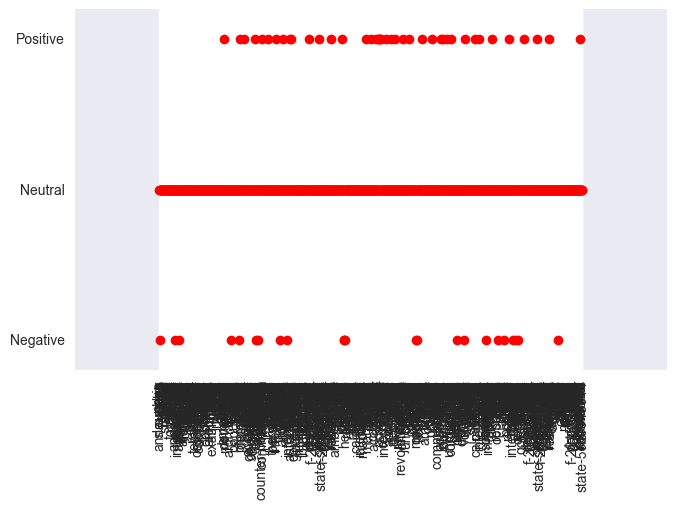

In [53]:
nltk.sentiment.util.demo_liu_hu_lexicon(df_email.ExtractedBodyText[13], plot=True)

In [145]:
def my_demo_liu_hu_lexicon(sentence, plot=False):
    """
    Basic example of sentiment classification using Liu and Hu opinion lexicon.
    This function simply counts the number of positive, negative and neutral words
    in the sentence and classifies it depending on which polarity is more represented.
    Words that do not appear in the lexicon are considered as neutral.
    :param sentence: a sentence whose polarity has to be classified.
    :param plot: if True, plot a visual representation of the sentence polarity.
    """
    from nltk.corpus import opinion_lexicon
    from nltk.tokenize import treebank

    tokenizer = treebank.TreebankWordTokenizer()
    pos_words = 0
    neg_words = 0
    neut_words = 0
    tokenized_sent = [word.lower() for word in tokenizer.tokenize(sentence)]

    x = list(range(len(tokenized_sent))) # x axis for the plot
    y = []

    for word in tokenized_sent:
        if word in opinion_lexicon.positive():
            print('positive: ',word)
            pos_words += 1
            y.append(1) # positive
        elif word in opinion_lexicon.negative():
            print('negative: ', word)
            neg_words += 1
            y.append(-1) # negative
        else:
            neut_words += 1
            y.append(0) # neutral
    print('Positive words: ', pos_words)
    print('Negative words: ', neg_words)
    print('Neutral words: ', neut_words)

    if pos_words > neg_words:
        print('Positive')
    elif pos_words < neg_words:
        print('Negative')
    elif pos_words == neg_words:
        print('Neutral')


In [146]:
my_demo_liu_hu_lexicon(df_email.ExtractedBodyText[13])

negative:  slaughter
negative:  slaughter
negative:  slaughter
positive:  support
negative:  issue
negative:  cynical
positive:  support
positive:  support
positive:  support
negative:  violent
negative:  hard
positive:  thoughtful
positive:  important
positive:  right
negative:  falling
positive:  important
negative:  opposition
positive:  astonishingly
positive:  support
positive:  support
positive:  sensitive
positive:  sensitive
positive:  decisive
negative:  inflict
negative:  damage
negative:  tanks
positive:  survivor
positive:  regard
positive:  capable
positive:  enough
positive:  gain
positive:  advantage
positive:  enough
positive:  willing
positive:  well
positive:  work
positive:  rosy
positive:  wins
negative:  massacres
negative:  opposition
positive:  support
positive:  promises
positive:  accomplish
positive:  intelligence
positive:  easier
positive:  neat
negative:  reluctance
negative:  ragged
positive:  brave
positive:  well
positive:  intelligence
negative:  opposi

In [142]:
# df_email.ExtractedBodyText[13]

In [49]:
pydic = {'Switzerland': {'CH':[0.2, 0.5, 1.5], 'Suisse': [1,2,3]}, 'Germany':{'GE': [2,2.1, 6, 8], 'Allemagne': [2]} }

In [52]:
pydic.get('Switzerland').get('CH')

[0.2, 0.5, 1.5]

In [19]:
pydic

{'hello': [2, 2.1, 6, 8, 3], 'hey': [0.2, 0.5, 1.5]}

In [48]:
for a in pydic:
    print(pydic.get(a))

[2, 2.1, 6, 8, 3]
[0.2, 0.5, 1.5]
